# Bonus material : Demonstrating Iris mesh concepts

This notebook provides a brief glimpse into the content of a `cube.mesh`.

This is not usually relevant to ordinary data processing in Iris, or to plotting in PyVista.

Goals :
  * introduce mesh coordinates + connectivities
  * show real LFRic mesh structure on plots

In [1]:
import numpy as np
from pv_conversions import pv_from_lfric_cube

In [2]:
## TODO : remove later -- this bit is temporary, for initial testing with C48 data
from testdata_fetching import switch_data
switch_data(use_newer_smaller_c48_data=True)

In [3]:
from testdata_fetching import lfric_rh_singletime_2d
cube = lfric_rh_singletime_2d()
print(cube)

relative_humidity_at_screen_level / (1) (-- : 13824)
    Mesh coordinates:
        latitude                            x
        longitude                           x
    Mesh:
        name                            Topology data of 2D unstructured mesh
        location                        face
    Scalar coordinates:
        forecast_period                 21600 seconds
        forecast_reference_time         2021-03-24 00:00:00
        time                            2021-03-24 06:00:00
    Cell methods:
        point                           time
    Attributes:
        Conventions                     'CF-1.7'
        description                     'Created by xios'
        interval_operation              '6 h'
        interval_write                  '6 h'
        online_operation                'instant'
        title                           'Created by xios'


In [4]:
# Snapshot the original data range -- this is useful below
data_min, data_max = cube.data.min(), cube.data.max()
data_range = data_max - data_min

In [5]:
# Calculate the coordinates of a cubesphere corner
x_corner = 45.0
y_corner = np.rad2deg(np.arctan(1.0 / np.sqrt(2)))
y_corner, x_corner

(35.264389682754654, 45.0)

## Get coordinates of node locations, from the mesh.

In [6]:
x_nodes_coord = cube.mesh.coord(axis='x', include_nodes=True)
y_nodes_coord = cube.mesh.coord(axis='y', include_nodes=True)
x_nodes_coord

<AuxCoord: longitude / (degrees)  <lazy>  shape(13826,)>

---
## Find the number of the node nearest one corner of the cubesphere

In [7]:
xx = x_nodes_coord.points
yy = y_nodes_coord.points
xy_dists = (xx -  x_corner) ** 2 + (yy - y_corner) ** 2
closest = np.min(xy_dists)
i_node_nearest_corner = np.argmin(xy_dists)

# show the results
print(
    'corner index :',
    i_node_nearest_corner
)
print('Some corner-distances around the corner node.. : ')
print('   ', xy_dists[i_node_nearest_corner - 2:i_node_nearest_corner + 3]
)

corner index : 97
Some corner-distances around the corner node.. : 
    [4.2551804e+00 3.0581756e+00 0.0000000e+00 8.1119761e+03 7.7729966e+03]


---
## Find the faces which touch that (corner) node

In [8]:
# (spoiler alert : if we specced the corner right, there are probably 3 of them)
face_nodes = cube.mesh.face_node_connectivity.indices
assert face_nodes.ndim == 2 and face_nodes.shape[1] == 4

In [9]:
face_on_corner = np.any(face_nodes == i_node_nearest_corner, axis=1)
corner_faces = np.where(face_on_corner)[0]
print('corner face indices :', corner_faces)

corner face indices : [   47  2304 11472]


---
## Modify the cube data, to "mark" those faces visibly, and display

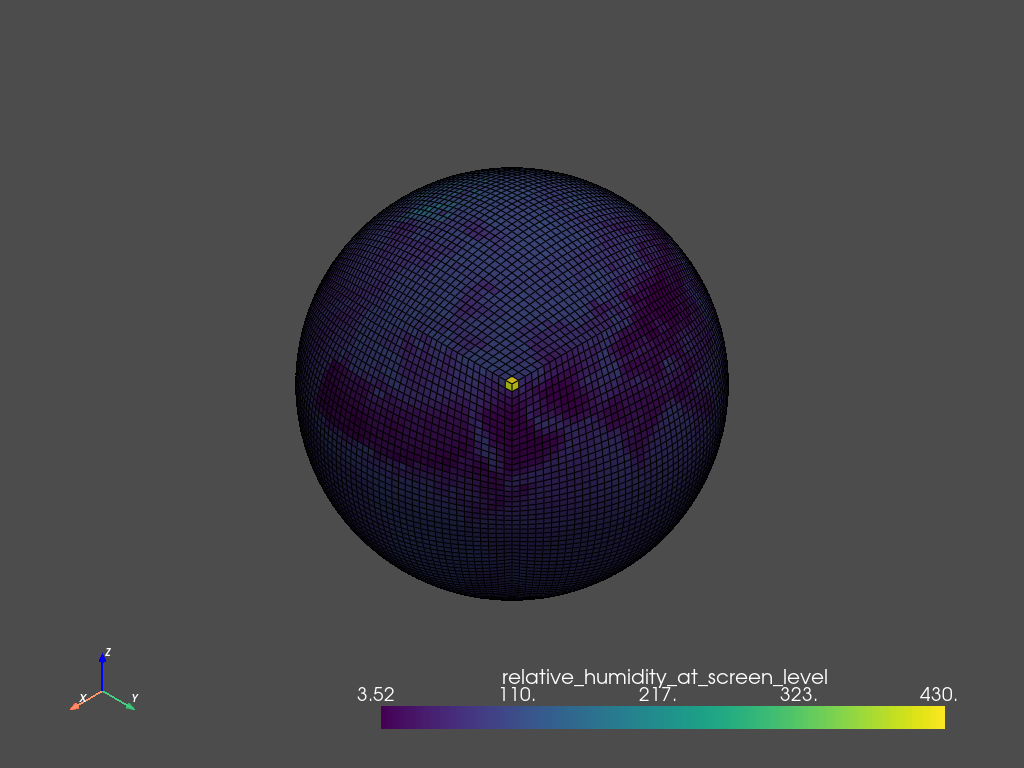

In [10]:
marks = data_max + data_range * np.array([1.2, 1.3, 1.4])
cube.data[corner_faces] = marks

# Plot the cube
pv = pv_from_lfric_cube(cube)
pv.plot(show_edges=True, jupyter_backend='static')

---

## "Expand" these selected faces outwards   
.. to include all the faces adjacent to these ones ...

Using the `face_node_connectivity` array again.

In [11]:
# **First** find all points which are corners of those faces
extended_points = cube.mesh.face_node_connectivity[corner_faces].indices
extended_points

masked_array(
  data=[[   94,    96,    97,    95],
        [   96,  2401,  2402,    97],
        [   95,    97,  2402, 11570]],
  mask=False,
  fill_value=999999,
  dtype=int32)

In [12]:
# Tidy to get sorted + unique point indices
extended_points = sorted(set(extended_points.flatten()))
print(extended_points)

[94, 95, 96, 97, 2401, 2402, 11570]


In [13]:
# ... **Then** find all faces which use those points (as before)
extended_faces = []
for i_point in extended_points:
    face_touches_point = np.any(face_nodes == i_point, axis=1)
    extended_faces.extend(np.where(face_touches_point)[0])

# tidy for sorted + unique, again
extended_faces = sorted(set(extended_faces))
print(extended_faces)

[46, 47, 94, 95, 2304, 2305, 2352, 2353, 11424, 11425, 11472, 11473]


---
### Mark all those faces too in the data
Distinguishing "outer" and "inner".

And re-plot ...

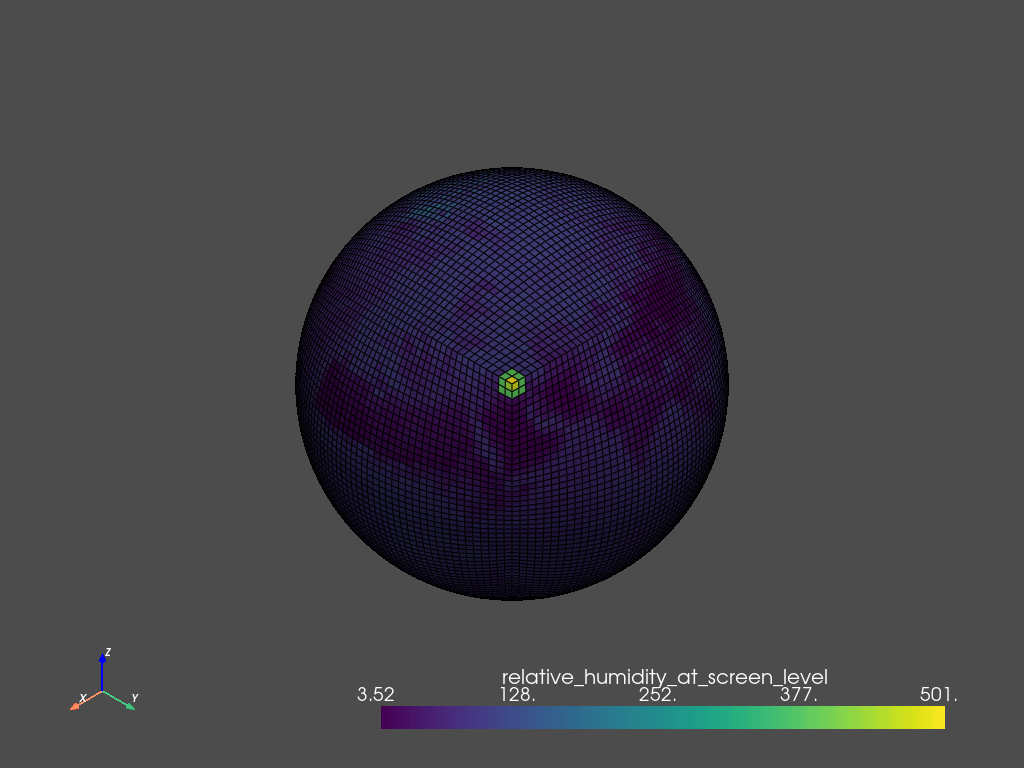

In [14]:
cube.data[extended_faces] = data_max + data_range * 1.1
cube.data[corner_faces] = data_max + data_range * np.array([1.4, 1.6, 1.8])
pv = pv_from_lfric_cube(cube)
pv.plot(show_edges=True, jupyter_backend='static')